In [9]:
# imports 
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm
import pickle

import lightning as L
seed = 42
L.seed_everything(seed, workers=True)

import xarray as xr
import xskillscore as xs
import warnings
import os


from src.models.unet_module import UnetLitModule
from src.models.gan_module import UnetGANLitModule
from src.models.ae_module import AutoencoderKL, EncoderLRES
from src.models.ldm_module import LatentDiffusion

from src.models.components.unet import DownscalingUnet
from src.models.components.ae import SimpleConvDecoder, SimpleConvEncoder
from src.models.components.ldm.denoiser import UNetModel, DDIMSampler
from src.models.components.ldm.conditioner import AFNOConditionerNetCascade
from src.data.downscaling_datamodule import DownscalingDataModule
from src.data.components.downscaling_dataset import DownscalingDataset

from utils.inference_utils import get_model_output
from utils.plotting_utils import get_target_grid, show_metrics, from_torchtensor_to_xarray

[rank: 0] Global seed set to 42


In [10]:
# Setting paths to data

# results_file_path = '../outputs/results_pde.pkl'
results_file_path = '../outputs/Our_results_trained_models_2mT.pkl'
pretrained_metrics_file_path = '../pretrained_models/outputs/metrics_trained_models.pkl'
output_path = '../outputs/'

In [11]:
#Loading in dataframes

results_df = pd.read_pickle(results_file_path)
pretrained_metrics_df = pd.read_pickle(pretrained_metrics_file_path)

In [12]:
#printing head and tails

print(results_df.columns)
print(results_df.shape)
print(results_df.head())
print(results_df.tail())

print_metrics = True
if print_metrics:
    print(f'\n\n =======================Pretrained Metrics below======================= \n\n')

    print(pretrained_metrics_df.columns)
    print(pretrained_metrics_df.shape)
    print(pretrained_metrics_df.head())
    print(pretrained_metrics_df.tail())
    print(pretrained_metrics_df['metric'].unique().tolist())

Index(['input_var', 'target_var', 'model', 'variable', 'spat_distr', 'min',
       'max', 'time_step'],
      dtype='object')
(35, 8)
  input_var target_var model variable  \
0       all        2mT  ERA5      2mT   
1       all        2mT  ERA5      2mT   
2       all        2mT  ERA5      2mT   
3       all        2mT  ERA5      2mT   
4       all        2mT  ERA5      2mT   

                                          spat_distr         min         max  \
0  [[tensor(282.5619), tensor(282.5619), tensor(2...  272.312256  290.437225   
1  [[tensor(273.5626), tensor(273.5626), tensor(2...  258.944519  289.312317   
2  [[tensor(287.2497), tensor(287.2497), tensor(2...  281.060699  300.498718   
3  [[tensor(289.4377), tensor(289.4377), tensor(2...  275.939758  301.378571   
4  [[tensor(277.4988), tensor(277.4988), tensor(2...  269.379364  290.562653   

            time_step  
0 2014-04-24 02:00:00  
1 2014-12-28 03:00:00  
2 2019-09-02 02:00:00  
3 2006-05-14 10:00:00  
4 2016-05-02 04:00

In [13]:
# split results_df into separate dataframes, one per model

model_types = results_df['model'].unique().tolist()

results = {}
for model_type in model_types:
    model_df = results_df[results_df['model'] == model_type]
    model_df = model_df.reset_index(drop=True)
    results[model_type] = model_df

print(results.keys())

dict_keys(['ERA5', 'COSMO-CLM', 'Quadratic Interp.', 'UNET', 'GAN', 'LDM_res', 'LDM_PDE_res'])


In [14]:
# Computing metrics for each model
metric_models = [model for model in model_types if model not in ['ERA5', 'COSMO-CLM']]
metrics_list = []

target_grid_high_res = get_target_grid('high')

for model_i in metric_models:
    for ts_idx, model_i_row in results[model_i].iterrows():
        # Extracting the corresponding target data
        cosmo_row = results['COSMO-CLM'].iloc[ts_idx]
        assert(cosmo_row['time_step'] == model_i_row['time_step'] and
               cosmo_row['input_var'] == model_i_row['input_var'] and
               cosmo_row['target_var'] == model_i_row['target_var'] and
               cosmo_row['variable'] == model_i_row['variable'])

        cosmo_spat_distr = cosmo_row['spat_distr']
        model_i_spat_distr = model_i_row['spat_distr']

        cosmo_xr = from_torchtensor_to_xarray(cosmo_spat_distr, target_grid_high_res, coords_name='y_x')
        model_i_xr = from_torchtensor_to_xarray(model_i_spat_distr, target_grid_high_res, coords_name='y_x')

        # Computing the 4 metrics listed in Appendix B
        model_i_rmse = xs.rmse(model_i_xr, cosmo_xr).item() # RMSE
        model_i_me = xs.me(model_i_xr, cosmo_xr).item() # BIAS (mean error)
        model_i_r2 = xs.r2(model_i_xr, cosmo_xr).item() # coefficient of determination
        model_i_pearson = xs.pearson_r(model_i_xr, cosmo_xr).item() # Pearson correlation

        # Appending the metrics to the list
        model_i_metrics = {
            'RMSE': model_i_rmse,
            'R2': model_i_r2,
            'BIAS': model_i_me,
            'PCC': model_i_pearson
        }

        for model_i_metric in model_i_metrics:
            metrics_list.append({
                'model': model_i,
                'target_var': model_i_row['target_var'],
                'var': model_i_row['variable'],
                'metric': model_i_metric,
                'value': model_i_metrics[model_i_metric],
            })

metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.reset_index(drop=True)

print(metrics_df)
metrics_df.to_pickle(output_path + './Our_inference_metrics' + '.pkl')  

                model target_var  var metric     value
0   Quadratic Interp.        2mT  2mT   RMSE  1.901043
1   Quadratic Interp.        2mT  2mT     R2  0.775449
2   Quadratic Interp.        2mT  2mT   BIAS -0.696168
3   Quadratic Interp.        2mT  2mT    PCC  0.897757
4   Quadratic Interp.        2mT  2mT   RMSE  1.952612
..                ...        ...  ...    ...       ...
95        LDM_PDE_res        2mT  2mT    PCC  0.977213
96        LDM_PDE_res        2mT  2mT   RMSE  0.854957
97        LDM_PDE_res        2mT  2mT     R2  0.963736
98        LDM_PDE_res        2mT  2mT   BIAS  0.077922
99        LDM_PDE_res        2mT  2mT    PCC  0.981936

[100 rows x 5 columns]


[Done] Super-grid PDE flux ratio metrics computed and appended to metrics_df.


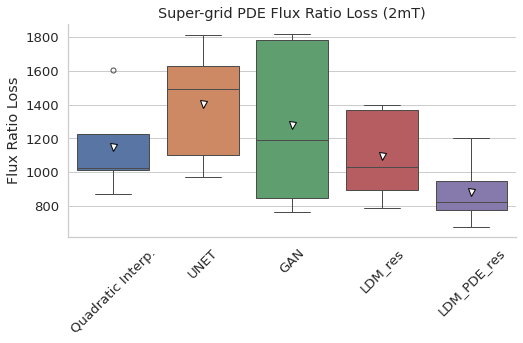

               model target_var  var metric     value
0  Quadratic Interp.        2mT  2mT   RMSE  1.901043
1  Quadratic Interp.        2mT  2mT     R2  0.775449
2  Quadratic Interp.        2mT  2mT   BIAS -0.696168
3  Quadratic Interp.        2mT  2mT    PCC  0.897757
4  Quadratic Interp.        2mT  2mT   RMSE  1.952612
5  Quadratic Interp.        2mT  2mT     R2  0.928309
6  Quadratic Interp.        2mT  2mT   BIAS  0.651627
7  Quadratic Interp.        2mT  2mT    PCC  0.968924
8  Quadratic Interp.        2mT  2mT   RMSE  2.872576
9  Quadratic Interp.        2mT  2mT     R2  0.619683


In [15]:
# === New Code Cell: Compute and Plot Super-Grid PDE Flux Ratio Metric ===

import torch
import numpy as np

###############################################################################
# GPU-accelerated supercell flux ratio code (already shown in the inference script)
###############################################################################
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_gradients_torch(T, dx=1.0, dy=1.0, eps=1e-6):
    H, W = T.shape
    dTdx = torch.zeros_like(T)
    dTdy = torch.zeros_like(T)
    # Interior
    if W > 2:
        dTdx[:, 1:-1] = (T[:, 2:] - T[:, :-2]) / (2.0 * dx)
    if H > 2:
        dTdy[1:-1, :] = (T[2:, :] - T[:-2, :]) / (2.0 * dy)
    # Boundaries
    if W > 1:
        dTdx[:, 0] = (T[:, 1] - T[:, 0]) / dx
        dTdx[:, -1] = (T[:, -1] - T[:, -2]) / dx
    if H > 1:
        dTdy[0, :] = (T[1, :] - T[0, :]) / dy
        dTdy[-1, :] = (T[-1, :] - T[-2, :]) / dy
    return dTdx, dTdy

def compute_block_effective_flux_ratio_torch(
    T_block, dTdx_block, dTdy_block, dx=1.0, dy=1.0, eps=1e-6
):
    device = T_block.device
    H, W = T_block.shape
    adv_vals, diff_vals = [], []
    
    def process_edge(i_idx, j_idx, nx, ny):
        grad_x = dTdx_block[i_idx, j_idx]
        grad_y = dTdy_block[i_idx, j_idx]
        Tvals  = T_block[i_idx, j_idx]
        grad_norm = torch.sqrt(grad_x**2 + grad_y**2) + eps
        g_hat_x = grad_x / grad_norm
        g_hat_y = grad_y / grad_norm
        dot = g_hat_x * nx + g_hat_y * ny
        adv_ = Tvals * dot
        diff_ = torch.sqrt(grad_x**2 + grad_y**2)
        return adv_, diff_
    
    # Top Edge
    if H > 0:
        i_top = torch.zeros(W, dtype=torch.long, device=device)
        j_top = torch.arange(W, device=device)
        adv, dif = process_edge(i_top, j_top, nx=0.0, ny=-1.0)
        adv_vals.append(adv)
        diff_vals.append(dif)
    # Bottom Edge
    if H > 1:
        i_bot = torch.full((W,), H - 1, dtype=torch.long, device=device)
        j_bot = torch.arange(W, device=device)
        adv, dif = process_edge(i_bot, j_bot, nx=0.0, ny=1.0)
        adv_vals.append(adv)
        diff_vals.append(dif)
    # Left Edge
    if W > 0 and H > 2:
        i_left = torch.arange(1, H - 1, device=device)
        j_left = torch.zeros(H - 2, dtype=torch.long, device=device)
        adv, dif = process_edge(i_left, j_left, nx=-1.0, ny=0.0)
        adv_vals.append(adv)
        diff_vals.append(dif)
    # Right Edge
    if W > 1 and H > 2:
        i_right = torch.arange(1, H - 1, device=device)
        j_right = torch.full((H - 2,), W - 1, dtype=torch.long, device=device)
        adv, dif = process_edge(i_right, j_right, nx=1.0, ny=0.0)
        adv_vals.append(adv)
        diff_vals.append(dif)
    
    if len(adv_vals) == 0:
        return 0.0

    adv_all = torch.cat(adv_vals)
    diff_all = torch.cat(diff_vals)
    return (torch.mean(adv_all) / (torch.mean(diff_all) + eps)).item()

def compute_supercell_flux_ratio_field(
    T, supercell_size=16, dx=1.0, dy=1.0, eps=1e-6
):
    device = get_device()
    if not isinstance(T, torch.Tensor):
        T_torch = torch.from_numpy(T).float().to(device)
    else:
        T_torch = T.float().to(device)
    H, W = T_torch.shape
    dTdx, dTdy = compute_gradients_torch(T_torch, dx=dx, dy=dy, eps=eps)
    num_cells_vert = H // supercell_size
    num_cells_horiz = W // supercell_size
    R_eff_field = torch.zeros((num_cells_vert, num_cells_horiz), device=device)
    for i in range(num_cells_vert):
        for j in range(num_cells_horiz):
            r0, r1 = i*supercell_size, (i+1)*supercell_size
            c0, c1 = j*supercell_size, (j+1)*supercell_size
            T_block    = T_torch[r0:r1, c0:c1]
            dTdx_block = dTdx[r0:r1, c0:c1]
            dTdy_block = dTdy[r0:r1, c0:c1]
            R_eff = compute_block_effective_flux_ratio_torch(T_block, dTdx_block, dTdy_block, dx=dx, dy=dy, eps=eps)
            R_eff_field[i, j] = R_eff
    return R_eff_field.cpu().numpy()

def compute_flux_ratio_loss_supercell(ref_field, pred_field, supercell_size=16, dx=1.0, dy=1.0, eps=1e-6):
    R_ref = compute_supercell_flux_ratio_field(ref_field, supercell_size, dx, dy, eps)
    R_pred = compute_supercell_flux_ratio_field(pred_field, supercell_size, dx, dy, eps)
    # If shapes differ, take overlap
    min_h = min(R_ref.shape[0], R_pred.shape[0])
    min_w = min(R_ref.shape[1], R_pred.shape[1])
    R_ref = R_ref[:min_h, :min_w]
    R_pred = R_pred[:min_h, :min_w]
    # PDE-style flux ratio difference = mean absolute difference
    return np.mean(np.abs(R_pred - R_ref))

###############################################################################
# Compute super-grid flux ratio metric for each model/time/2mT
###############################################################################
fluxratio_metrics_list = []
for model_i in metric_models:
    # Only do flux ratio for 2mT
    model_rows_2mt = results[model_i][results[model_i]['variable'] == '2mT']
    for idx, row in model_rows_2mt.iterrows():
        ts = row['time_step']
        # Matching ERA5 row => reference coarse
        era5_row = results['ERA5'][(results['ERA5']['time_step'] == ts) &
                                   (results['ERA5']['variable'] == '2mT')]
        if era5_row.empty:
            continue
        # Numpy or array data
        T_c = era5_row.iloc[0]['spat_distr'].numpy() if hasattr(era5_row.iloc[0]['spat_distr'],'numpy') \
             else era5_row.iloc[0]['spat_distr']
        T_f = row['spat_distr'].numpy() if hasattr(row['spat_distr'],'numpy') else row['spat_distr']
        
        flux_loss = compute_flux_ratio_loss_supercell(T_c, T_f, supercell_size=16, dx=1.0, dy=1.0, eps=1e-6)
        fluxratio_metrics_list.append({
            'model': model_i,
            'target_var': row['target_var'],
            'var': row['variable'],
            'metric': 'FluxRatio',
            'value': flux_loss,
        })

if fluxratio_metrics_list:
    fluxratio_df = pd.DataFrame(fluxratio_metrics_list)
    metrics_df = pd.concat([metrics_df, fluxratio_df], ignore_index=True)

print("[Done] Super-grid PDE flux ratio metrics computed and appended to metrics_df.")
metrics_df.to_pickle(output_path + './Our_inference_metrics_with_PDE.pkl')

###############################################################################
# Plot the distribution of "FluxRatio" metric, similar to other metrics
###############################################################################
import seaborn as sns
sns.set_theme(font_scale=1.2, style="whitegrid")

fluxratio_plot_df = metrics_df[metrics_df['metric'] == 'FluxRatio'].copy()
if len(fluxratio_plot_df) == 0:
    print("No 'FluxRatio' metrics found in metrics_df. Skipping super-grid PDE flux ratio plot.")
else:
    g = sns.catplot(
        data=fluxratio_plot_df, kind='box',
        x='model', y='value', hue='model',
        height=5, aspect=1.5, legend=False,
        showmeans=True,
        meanprops={'marker': 'v', 'markerfacecolor': 'white', 'markeredgecolor': 'black', 'markersize': 7}
    )
    for ax in g.axes.flatten():
        for label in ax.get_xticklabels():
            label.set_rotation(45)
        ax.set_xlabel("")
        ax.set_title("Super-grid PDE Flux Ratio Loss (2mT)")
        ax.set_ylabel("Flux Ratio Loss")
    
    # Adjust legend, remove duplicates
    if g._legend is not None:
        g._legend.remove()
    plt.tight_layout()
    plt.show()
# Append the flux ratio metrics to the existing metrics DataFrame
if fluxratio_metrics_list:
    fluxratio_df = pd.DataFrame(fluxratio_metrics_list)
    metrics_df = pd.concat([metrics_df, fluxratio_df], ignore_index=True)

# Save the updated metrics DataFrame to file
metrics_df.to_pickle(output_path + './Our_inference_metrics_with_PDE.pkl')

# (Optional) Print the head of the updated dataframe to verify the new entries
print(metrics_df.head(10))



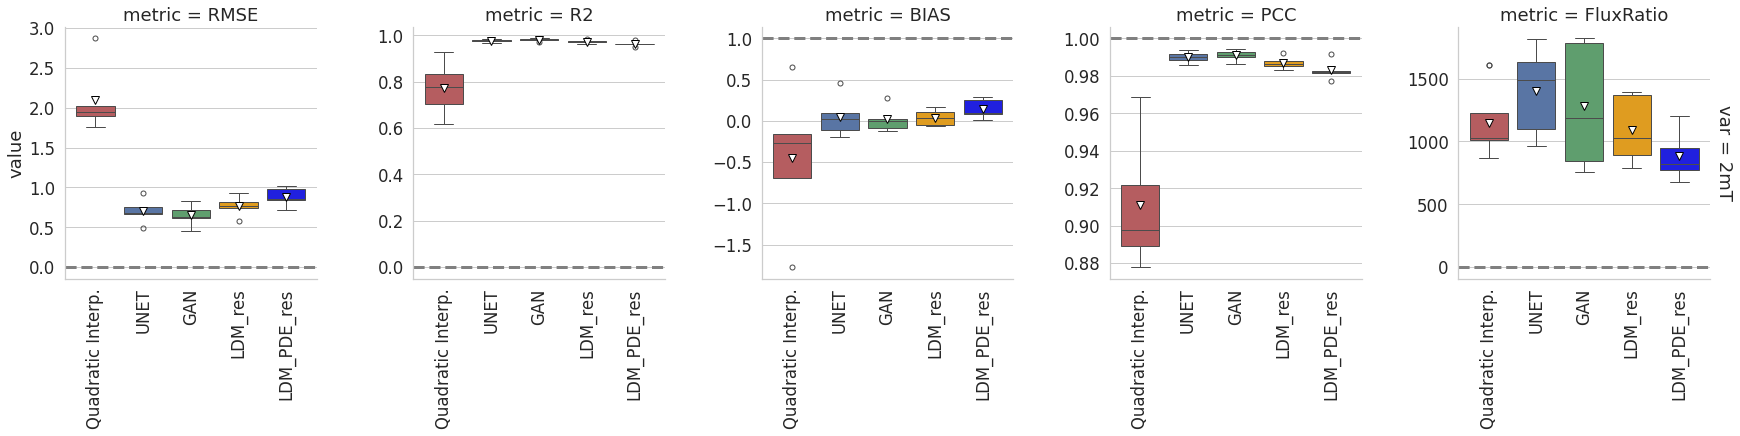

In [16]:
# Plotting metrics
def show_mT_metrics(metrics, output_dir, save_to_file):
    """
    Slightly modified version of show_metrics from utils.plotting_utils
    """

    # Set up plotting resources
    box_palette = {'Quadratic Interp.': 'r',
                'UNET':'b',
                'GAN': 'g',
                'VAE_res': 'pink',
                'LDM_res': 'orange',
                'LDM_PDE_res': 'blue'}
    y_ref = [0,0,1,1,0,0,1,1]
    # Plot boxplots
    sns.set_theme(font_scale=1.5, style="whitegrid")
    g = sns.catplot(data=metrics, kind='box', x="model", y="value", col="metric", row='var', hue='model', native_scale=True, sharey=False, margin_titles=True, palette=box_palette, showmeans=True,
                    meanprops={'marker':'v','markerfacecolor':'w','markeredgecolor':'black','markersize':'8'})
    for i,ax in enumerate(g.axes.flat):
        for label in ax.get_xticklabels():
            label.set_rotation(90)
        ax.axline((0, y_ref[i]), slope=0, linestyle='--', color='gray', linewidth=3)
        ax.set(xlabel=None)
    if g._legend is not None:
        g._legend.remove()

    if save_to_file:
        # Save to file
        g.savefig(output_dir + 'Fig_metrics.jpg')

show_mT_metrics(metrics_df, output_path, False)